here we generate the pseudo labels based on segmentation masks

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sideseeing_tools import sideseeing

ds_path = '/scratch/suayder/urbanaccess'
ds = sideseeing.SideSeeingDS(root_dir=ds_path)

In [34]:
def show_steps(steps):
    """step is a dict {operation_name: array_result}"""
    if len(steps) == 1:
        for title, image in steps.items():
            plt.imshow(image)
            plt.title(title)
        return

    len_images = len(steps)
    rows = int(np.sqrt(len_images))
    cols = int(np.ceil(len_images / rows))
    fig, axes = plt.subplots(rows, cols)
    axes = axes.flatten()
    for idx, (title, image) in enumerate(steps.items()):
            axes[idx].imshow(image, cmap='gray')
            axes[idx].set_title(title)
            axes[idx].axis('off')  # Hide axes ticks

    for idx in range(len_images, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()



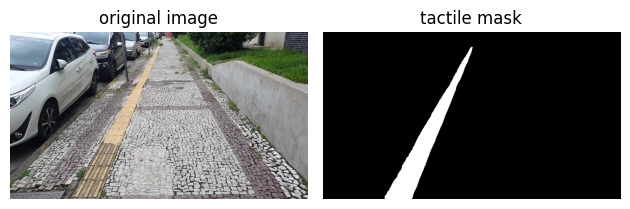

In [37]:
class InstancePaths:
    def __init__(self, instance):
        self.instance = instance

    def image(self, frame_number):
        return os.path.join(self.instance.path, 'images', str(frame_number).zfill(5)+'.jpg')

    def click(self, frame_number):
        return os.path.join(self.instance.path, 'clicks', str(frame_number).zfill(5)+'.txt')

    def masks(self, frame_number):
        return os.path.join(self.instance.path, 'mask', str(frame_number-1).zfill(5)+'.npy') # TODO: I changed this

    def att_map(self, frame_number):
        return os.path.join(self.instance.path, 'maps', str(frame_number).zfill(5)+'.png')


instance = InstancePaths(ds.instance)
track = {
    'original image': Image.open(instance.image(1)),
    'tactile mask': np.moveaxis(np.load(instance.masks(1)), 0, 2)
}
show_steps(track)

# preciso da imagem e mascara
# criar uma função para ir adicionando o processamento passo a passo

# run for image
# run for instance
# run for dataset 

In [20]:
find irrecularities in the image

clicks		 images      metadata.json    sensors.three.csv
consumption.csv  labels.txt  seg_mask	      sensors.three.uncalibrated.csv
gps.csv		 mask	     sensors.one.csv  video.mp4
